# Project: App-Review Miner
Team members: Shanshan Li, Yingyezhe Jin, Tianshu Chu, Xiao Huang

In [10]:
# Put all import here
import numpy as np
import lda
import lda.datasets

### NLP based preprocessing

    Inputs:  datasetName
             rmStopWords control to remove stop words
             rmRareWords control to remove rarely occured words
             
    Outputs: trainSet    is a list of training reviews
             testSet     is a list of testing reviews
             unlabelSet  is a list of unlabeld reviews
             vocabulary  is the corresponding n vocabulary in a dictionary form {word, index}

In [76]:
%run ./AR_util.py
%run ./AR_reviewInstance.py
datasetName = "templerun2" # four apps : facebook, templerun2, swiftkey, tapfish

rmStopWords = True # Removing stop words lead to information loss and bad f-score
rmRareWords = True

# trainSet/testSet/unlabel: dictionary of {label, reviews} for review data
# vocabulary: dictionary len = V and the positional index of each term in the doc vector
# set skParse True to directly read of the data that has been filtered out
skParse = False
if(skParse == False):
    # the vocabulary is the words on the training set!
    trainSet, testSet, unlabelSet, vocabulary = AR_parse(datasetName, rmStopWords, rmRareWords)

Vocabulary size for templerun2 : 5283
Training set Size: 1000
Testing set Size: 2000
Unlabeling set Size: 57559


### Naive Bayes based filtering

    Inputs:  train/test/unlabelSet   are the preprocessed reviews 
             vocabulary              is the corresponding vocabulary of the reviews
    Outputs: informMat    is a k*m np sparse matrix, k is the number of informative reviews, m is the length of vocabulary
             informRev    is a list of informative reviews

In [77]:
%run ./AR_classifier.py
# 1. Use the EM-NB or SVM to filter out the informative reviews
# informMat: the informative reviews in X x V sparse matrix from, X: documents size, V: vocabulary size
# informRev: corresponding reviews wrapped as a list of review instances
useSVM = True # SVM is way better than emnb in terms of the testing. 
               # But it may not filter out the information effectively
if(skParse == False):
    if(useSVM == False):
        informRev, informMat = AR_emnb(trainSet, testSet, unlabelSet, vocabulary, datasetName)
    else:
        informRev, informMat = AR_svm(trainSet, testSet, unlabelSet, vocabulary, datasetName)

    # write the result back to the file (optional)
    AR_writeReviews(informRev, datasetName)
else:
    # directly read from the file
    informRev, informMat, vocabulary = AR_loadReviews(datasetName)

print("Number of informative reviews: " + str(len(informRev)))

Average F-Score for the test data: 0.829510754251
Number of informative reviews: 13672


### LDA topic clustering

    Inputs:  informMat  is the k*m np sparse matrix, k is the number of informative reviews, m  is the length of vocabulary
             informRev  is the informative review list
             vocabulary is the corresponding vocabulary dictionary
             n_topics   is the number of topics
    Outputs: doc_topic  is a k*n_topics np matrix, which indicates the probability
             vocab      is the vocabulary in the list form

In [78]:
%run ./AR_lda.py
# 2. Use the LDA to do the grouping based on the topic
# doc_topi : a k*n_topics np matrix, which indicates the probability of each review belongs to one of the topic
# vocab: a list of vocabulary words
n_topics = 20
doc_topic, vocab = AR_lda(informRev, informMat, vocabulary, n_topics)


INFO:lda:n_documents: 13672
INFO:lda:vocab_size: 5283
INFO:lda:n_words: 107573
INFO:lda:n_topics: 20
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -1159718
INFO:lda:<500> log likelihood: -715181
INFO:lda:<999> log likelihood: -714484


Topic 0: screen load back imangi open close home
Topic 1: coin get game upgrad keep purchas collect
Topic 2: game good littl bit lag sometim realli
Topic 3: power coin one powerup magnet get time
Topic 4: lag game phone freez sometim awesom xperia
Topic 5: game need new charact like make could
Topic 6: fix star pleas give game problem would
Topic 7: game screen play even score sound turn
Topic 8: save game use crash gem time tri
Topic 9: sensit tilt need option control improv could
Topic 10: wont play even let open phone game
Topic 11: turn tilt jump right phone side sometim
Topic 12: download fix galaxi pleas samsung error say
Topic 13: object coin level get complet lifetim still
Topic 14: game freez lag die get start time
Topic 15: lag game updat graphic run great even
Topic 16: sometim run get boost go speed jump
Topic 17: game take time play download good htc
Topic 18: run templ one first like better game
Topic 19: close time forc open play tri game


### Ranking all the groups based on importance

    Inputs:  doc_topic      is a k*n_topics np matrix, which indicates the probability
             wg             is a row vector (1 * 2), where each element denotes the weight of the corresponding feature
             informRev      is the informative review list
    Outputs: group_scores   is a row vector (1 * 20), where each element is the score of the corresponding group
             sorted_indices is a row vector (1 * 20), where the ith element is the index of the group whose score is the ith largest

In [79]:
%run ./AR_ranker.py
wg = [0.85, 0.15]
group_scores, sorted_group_indices = group_rank(doc_topic, wg, informRev)
print('group scores:\n')
print(group_scores)
print('ranked indices:\n')
print(sorted_group_indices)

group scores:

[691.6676028296182, 678.94141842819181, 645.99005302561773, 645.01767718730753, 643.68260648137698, 623.28982050408138, 621.1742499000834, 597.27861838270064, 590.23466534856868, 585.2647975835481, 578.58789267004136, 556.9458657957141, 551.02200399000037, 542.82780585311218, 539.66398503350183, 538.95665828765777, 516.7252512056715, 512.8350230872594, 492.21835380658217, 469.88265614751185]
ranked indices:

[0, 1, 19, 9, 10, 2, 14, 5, 6, 8, 11, 13, 12, 17, 15, 4, 18, 16, 3, 7]


### Cluster the reviews using volume and use TextRank to rank each instance

    Inputs:  doc_topic  is a np matrix k*n_topic, where k is # of reviews
             informRev  is a list of all informative reviews
    Outputs: rankedInstance is a dict = {topic, list of ranked reviews with the score}

In [80]:
%run ./AR_textrank.py
AR_tfIdf(informRev)
rankedInstance = AR_textrank(doc_topic, informRev)

In construct the graph of reviews ---- Nodes: 1028 Edges: 41878
In construct the graph of reviews ---- Nodes: 1043 Edges: 17482
In construct the graph of reviews ---- Nodes: 928 Edges: 20648
In construct the graph of reviews ---- Nodes: 565 Edges: 5034
In construct the graph of reviews ---- Nodes: 679 Edges: 10312
In construct the graph of reviews ---- Nodes: 741 Edges: 5402
In construct the graph of reviews ---- Nodes: 664 Edges: 11320
In construct the graph of reviews ---- Nodes: 484 Edges: 3098
In construct the graph of reviews ---- Nodes: 728 Edges: 22898
In construct the graph of reviews ---- Nodes: 822 Edges: 25402
In construct the graph of reviews ---- Nodes: 799 Edges: 39180
In construct the graph of reviews ---- Nodes: 681 Edges: 8758
In construct the graph of reviews ---- Nodes: 573 Edges: 21804
In construct the graph of reviews ---- Nodes: 583 Edges: 9628
In construct the graph of reviews ---- Nodes: 681 Edges: 7914
In construct the graph of reviews ---- Nodes: 545 Edges: 67

In [81]:
# print the top 10 reviews:
for i in range(len(rankedInstance)):
    print("Instance review for topic group: " + str(i))
    for j in range(5):
        r_ind = rankedInstance[i][j][0]
        score = rankedInstance[i][j][1]
        print(str(j+1) + "th review " + "Text: " +  informRev[r_ind].text + " Score: " + str(score) )

Instance review for topic group: 0
1th review Text: doesnt open on dell streak 5 Score: 0.000999200639146
2th review Text: dosent open on my dell streak Score: 0.000999200639146
3th review Text: android 2 2 2 dell streak 5 please check since it crashes to home screen without showing error Score: 0.000999200639146
4th review Text: when i open with my lg thrill i get the imangi studios icon like normal but then it closes down Score: 0.000999200639146
5th review Text: with a stock dell streak all i get is a force close Score: 0.000999200639146
Instance review for topic group: 1
1th review Text: after a couple runs i lose all of my coins except for a few hundred and then my coins from the run i ve just finished will add onto those couple hundred Score: 0.00103103412663
2th review Text: noticed coins disappear they dont stay when iver a certain amount so u can never get 5000 or 10000 coins i got the 1000000 coin mark for tge level n didnt even see or use them Score: 0.00103103412663
3th rev

### Ranking all the reviews in each group based on their importance score

    Inputs: doc_topic             is a k*n_topics np matrix, which indicates the probability
            weight                is a row vector (1 * 3), where each element denotes the weight of the corresponding feature
    Outputs: topic_top10RevScores is a row vector (10 * 20), where each element is the ranked score of the corresponding review in each group

In [82]:
%run ./AR_reviewRanking.py
AR_tfIdf(informRev)
weight = [0.25, 0.25, 0.25, 0.25]
topic_top10RevScores = instance_ranking(doc_topic, weight, informRev)

Length of 0th topic has reviews: 1218
Length of 1th topic has reviews: 1236
Length of 2th topic has reviews: 1191
Length of 3th topic has reviews: 747
Length of 4th topic has reviews: 964
Length of 5th topic has reviews: 1099
Length of 6th topic has reviews: 1156
Length of 7th topic has reviews: 753
Length of 8th topic has reviews: 1045
Length of 9th topic has reviews: 1173
Length of 10th topic has reviews: 1191
Length of 11th topic has reviews: 1072
Length of 12th topic has reviews: 940
Length of 13th topic has reviews: 900
Length of 14th topic has reviews: 1175
Length of 15th topic has reviews: 967
Length of 16th topic has reviews: 878
Length of 17th topic has reviews: 971
Length of 18th topic has reviews: 955
Length of 19th topic has reviews: 1188


In [83]:
# print the top 10 reviews:
for i in range(len(topic_top10RevScores)):
    print("Instance review for topic group: " + str(i))
    for j in range(5):
        r_ind = topic_top10RevScores[i][j][0]
        score = topic_top10RevScores[i][j][1]
        print(str(j+1) + "th review " + "Text: " +  informRev[r_ind].text + " Score: " + str(score) )

Instance review for topic group: 0
1th review Text: opens and says imangi studios then closes and sends me to my home page Score: 0.9525
2th review Text: when i open game it shows imangi studio symbol in green but then closes out Score: 0.9525
3th review Text: i open it and the logo shows up and then it closes and goes to home screen Score: 0.947222222222
4th review Text: it stays on the imangi studios picture for a few seconds then force closes Score: 0.947222222222
5th review Text: sometimes when i try to play it just stay on the imangi screen and force closing idk why and it seems to lag a bit Score: 0.947222222222
Instance review for topic group: 1
1th review Text: paid 4 99 for the double coin thing Score: 0.905
2th review Text: i bought the double coins and it doesnt work wtf Score: 0.905
3th review Text: i did not receive the coins Score: 0.905
4th review Text: paid 4 99 for the double coin thing Score: 0.905
5th review Text: my coins are disappearing Score: 0.88125
Instance rev

### Visualization

    Inputs:  group_scores is a list of scores of each group
    Outputs: a radar chart

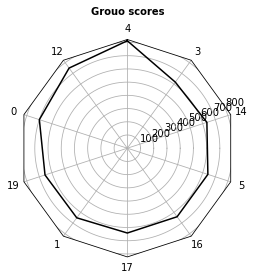

In [38]:
%run ./AR_visualization.py

N = 10
theta = radar_factory(N, frame='polygon')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='radar')
ax.set_title('Grouo scores', weight='bold', size='medium', position=(0.5, 1.1), horizontalalignment='center', verticalalignment='center')
ax.plot(theta, group_scores[0:10], color='k')
ax.set_varlabels(sorted_group_indices)
plt.show()